In [4]:
#
# Automatically generate daily plots of the Sagnac frequency, AC, DC and contrast values and
#
# Intends to provide a quick evaluation of the performance.
#

In [7]:
import os
import sys
import matplotlib.pyplot as plt

from pandas import read_pickle, read_csv, to_datetime, Timedelta
from obspy import UTCDateTime
from pprint import pprint


In [8]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def __load_sagnac_beat_data(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, merge
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    # generate dates with 1 minute samples
    dates = date_range(dd1, dd2, freq="1min")

    # prepare data frame
    df0 = DataFrame()

    # prepare dummy data frame
    df_dummy = DataFrame()

    # add column for merging
    df_dummy["dt"] = [str(UTCDateTime(_d))[:16] for _d in dates]

    # add column to replace nan from merging with proper dates
    df_dummy["dummy_times"] = [UTCDateTime(_d) for _d in dates]


    for dat in date_range(dd1, dd2):

        # build file name
        file = f"{str(dat)[:4]}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"

        try:
            df00 = read_pickle(path_to_data+file)
            df0 = concat([df0, df00])
        except:
            print(f"error for {file}")

    if df0.empty:
        print(" -> empty dataframe!")
        return df0

    # add column for merging
    df0["dt"] = [str(_dt)[:16] for _dt in df0.times_utc]

    try:
        df = merge(left=df_dummy, right=df0, on="dt", how="outer")
    except:
        print("-> no merge")

    # trim to given start and end date
    df = df[(df.dt >= tbeg) & (df.dt < tend)]

    # fill possible missing times_utc that turned to nan in merge with prepared dummy times
    df['times_utc'] = df['times_utc'].fillna(df['dummy_times'])

    # convert to UTCDateTime objects
    df['times_utc'] = [UTCDateTime(_t) for _t in df['times_utc']]

    # trim to defined times
    # df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    # correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t)) for _t in df['times_utc']]

    # remove helper columns
    df.drop(columns=["dt", "dummy_times"], inplace=True)

    return df

In [20]:
def __load_mlti(tbeg, tend, ring, path_to_archive):

    from obspy import UTCDateTime
    from pandas import read_csv, concat

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    rings = {"U":"03", "Z":"01", "V":"02", "W":"04"}

    if tbeg.year == tend.year:
        year = tbeg.year

        path_to_mlti = path_to_archive+f"romy_archive/{year}/BW/CROMY/{year}_romy_{rings[ring]}_mlti.log"

        mlti = read_csv(path_to_mlti, names=["time_utc","Action","ERROR"])

    else:

        path_to_mlti1 = path_to_archive+f"romy_archive/{tbeg.year}/BW/CROMY/{tbeg.year}_romy_{rings[ring]}_mlti.log"
        mlti1 = read_csv(path_to_mlti1, names=["time_utc","Action","ERROR"])

        path_to_mlti2 = path_to_archive+f"romy_archive/{tend.year}/BW/CROMY/{tend.year}_romy_{rings[ring]}_mlti.log"
        mlti2 = read_csv(path_to_mlti2, names=["time_utc","Action","ERROR"])

        mlti = concat([mlti1, mlti2])

    mlti = mlti[(mlti.time_utc > tbeg) & (mlti.time_utc < tend)]

    return mlti

In [67]:
config = {}

config['beagle'] = {"U":"03", "V":"02", "W":"04", "Z":"01"}

config['sagnac'] = {"U":302.47, "V":447.75, "W":447.5, "Z":553.58}

config['colors'] = {"U":"tab:purple", "V":"tab:blue", "W":"darkblue", "Z":"gold"}

config['interval'] = 2 # days

config['tend'] = UTCDateTime.now()
config['tbeg'] = config['tend']-config['interval']*86400

# path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"


# config['path_to_data'] = archive_path+f"romy_autodata/{config['year']}/R{config['ring']}/"

# config['path_to_figs'] = archive_path+f"romy_plots/{config['year']}/R{config['ring']}/signal/"

# config['path_to_mlti'] = archive_path+f"romy_archive/{config['year']}/BW/CROMY/{config['year']}_romy_{config['beagle'][config['ring']]}_mlti.log"

In [16]:
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])
beatW = __load_sagnac_beat_data(config['tbeg'], config['tend'], "W", config['path_to_autodata'])
beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])

error for 2024/RW/FJW_20240703.pkl
error for 2024/RW/FJW_20240704.pkl
error for 2024/RW/FJW_20240705.pkl
 -> empty dataframe!
error for 2024/RU/FJU_20240705.pkl
error for 2024/RZ/FJZ_20240705.pkl
error for 2024/RV/FJV_20240705.pkl


In [22]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)
# mltiW = __load_mlti(config['tbeg'], config['tend'], "W", archive_path)
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

In [76]:
def find_limits(df, key, thres_min, thres_max):
    _df = df.copy()
    _df = _df[(_df[key] > thres_min) & (_df[key] < thres_max)]
    return _df[key].min(), _df[key].max()

In [77]:
find_limits(beatU, "dc_z", 0, 1)

(0.35618105114975235, 0.3810077933950042)

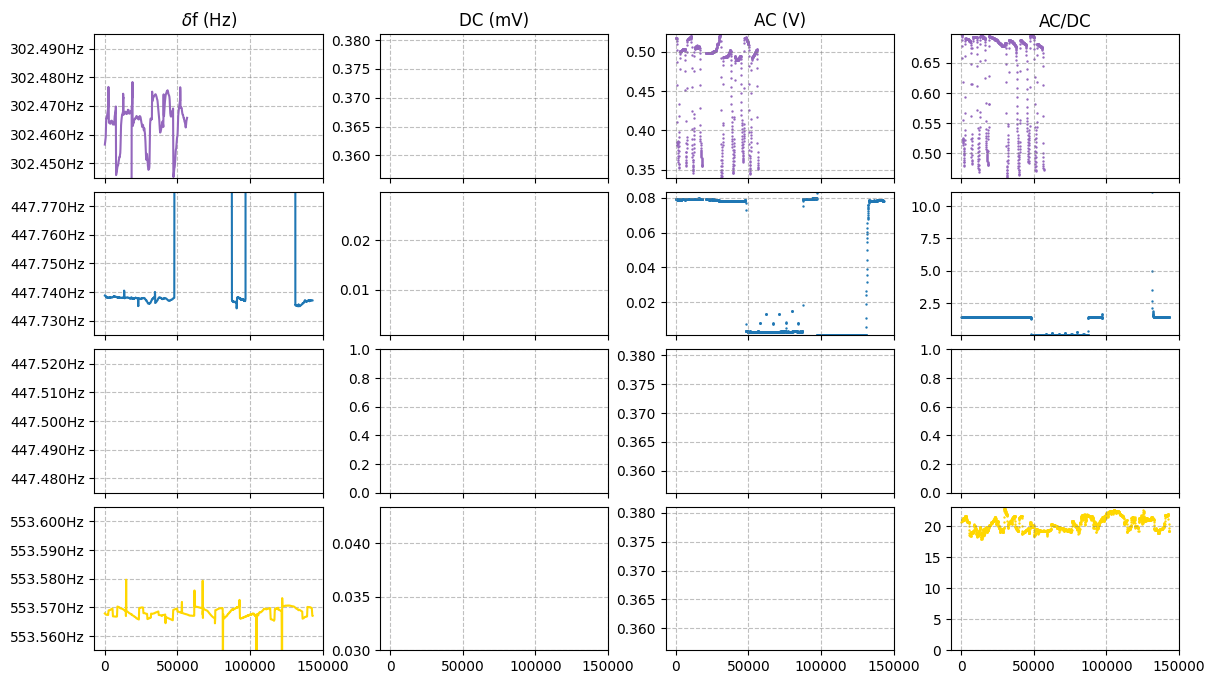

In [106]:
def __makeplot():

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    Nrow, Ncol = 4, 4

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(14, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1, wspace=0.25)

    try:
        ax[0, 0].plot(beatU.times_utc_sec, beatU.fj, color=config['colors']['U'], label=f"$\delta$f")
        ax[0, 1].scatter(beatU.times_utc_sec, beatU.dc_z*1e3, s=0.5, color=config['colors']['U'], label="DC")
        ax[0, 2].scatter(beatU.times_utc_sec, beatU.ac_z, s=0.5, color=config['colors']['U'], label="AC")
        ax[0, 3].scatter(beatU.times_utc_sec, beatU.contrast_z, s=0.5, color=config['colors']['U'], label="AC/DC")
    except:
        pass
    try:
        ax[1, 0].plot(beatV.times_utc_sec, beatV.fj, color=config['colors']['V'], label=f"$\delta$f")
        ax[1, 1].scatter(beatV.times_utc_sec, beatV.dc_z*1e3, s=0.5, color=config['colors']['V'], label="DC")
        ax[1, 2].scatter(beatV.times_utc_sec, beatV.ac_z, s=0.5, color=config['colors']['V'], label="AC")
        ax[1, 3].scatter(beatV.times_utc_sec, beatV.contrast_z, s=0.5, color=config['colors']['V'], label="AC/DC")
    except:
        pass
    try:
        ax[2, 0].plot(beatW.times_utc_sec, beatW.fj, color=config['colors']['W'], label=f"$\delta$f")
        ax[2, 1].scatter(beatW.times_utc_sec, beatW.dc_z*1e3, s=0.5, color=config['colors']['W'], label="DC")
        ax[2, 2].scatter(beatW.times_utc_sec, beatW.ac_z, s=0.5, color=config['colors']['W'], label="AC")
        ax[2, 3].scatter(beatW.times_utc_sec, beatW.contrast_z, s=0.5, color=config['colors']['W'], label="AC/DC")
    except:
        pass
    try:
        ax[3, 0].plot(beatZ.times_utc_sec, beatZ.fj, color=config['colors']['Z'], label=f"$\delta$f")
        ax[3, 1].scatter(beatZ.times_utc_sec, beatZ.dc_z*1e3, s=0.5, color=config['colors']['Z'], label="DC")
        ax[3, 2].scatter(beatZ.times_utc_sec, beatZ.ac_z, s=0.5, color=config['colors']['Z'], label="AC")
        ax[3, 3].scatter(beatZ.times_utc_sec, beatZ.contrast_z, s=0.5, color=config['colors']['Z'], label="AC/DC")
    except:
        pass

    # ax.set_ylim(0, 8000)

    for i in range(Nrow):
        for j in range(Ncol):
            ax[i, j].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
            ax[i, j].ticklabel_format(useOffset=False)
            # ax[i, j].legend(loc=1)
            ax[i, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3fHz'))
            ax[i, 2].set_ylim(find_limits(beatU, "dc_z", 0, 1))
            ax[i, 3].set_ylim(bottom=0)

    for i, _df in enumerate([beatU, beatV, beatW, beatZ]):
        try:
            ax[i, 1].set_ylim(find_limits(_df, "dc_z", 0, 1))
            ax[i, 2].set_ylim(find_limits(_df, "ac_z", 0, 1))
            ax[i, 3].set_ylim(find_limits(_df, "contrast_z", 0, 100))
        except:
            pass

    ax[0, 0].set_title("$\delta$f (Hz)")
    ax[0, 1].set_title("DC (mV)")
    ax[0, 2].set_title("AC (V)")
    ax[0, 3].set_title("AC/DC")

    deltaf = 0.025
    ax[0, 0].set_ylim(config['sagnac']['U']-deltaf, config['sagnac']['U']+deltaf)
    ax[1, 0].set_ylim(config['sagnac']['V']-deltaf, config['sagnac']['V']+deltaf)
    ax[2, 0].set_ylim(config['sagnac']['W']-deltaf, config['sagnac']['W']+deltaf)
    ax[3, 0].set_ylim(config['sagnac']['Z']-deltaf, config['sagnac']['Z']+deltaf)

    plt.show();
    return fig

fig = __makeplot();

In [ ]:
def main(config):

    # pprint(config)

    ## modify date
    date = config['date']
    utc_date = UTCDateTime(date)
    dt_date = to_datetime(date)


    ## read data
    filename = f"FJ{config['ring']}_{date.replace('-','')}"
    df = read_pickle(config['path_to_data']+filename+".pkl")

    ## read mlti log
    mlti = read_csv(config['path_to_mlti'], names=["datetime", "action"])

    ## add row with datetimes
    mlti['dt'] = to_datetime(mlti.index)

    ## filter for current date
    mlti = mlti[(mlti.dt > date) & (mlti.dt < dt_date + Timedelta(days=1))]

    ## add seconds column
    mlti['seconds'] = [abs(utc_date - UTCDateTime(t)) for t in mlti.dt]

    print(df)

    ## create figure
    try:
#        fig1 = __makeplot_overview1(df)
#        fig2 = __makeplot_overview2(df, mlti)
        fig3 = __makeplot_overview3(df, mlti)
    except Exception as e:
        print(" -> failed plotting ...")
        print(e)


    ## save figure
    out_filename = f"{date.replace('-','')}_signal_R{config['ring']}"

    print(f" -> saving figures to: {config['path_to_figs']}{out_filename}.png")

#     fig1.savefig(f"{config['path_to_figs']}{out_filename}_1.png", dpi=200, facecolor='w', bbox_inches='tight',
#                 edgecolor='w', orientation='portrait', format='png', transparent=False, pad_inches=0.1)
#    fig2.savefig(f"{config['path_to_figs']}{out_filename}_2.png", dpi=200, facecolor='w', bbox_inches='tight',
    fig3.savefig(f"{config['path_to_figs']}{out_filename}.png", dpi=200, facecolor='w', bbox_inches='tight',
                edgecolor='w', orientation='portrait', format='png', transparent=False, pad_inches=0.1)

## _______________________________________
if __name__ == "__main__":
    main(config)

## End of File